# Proyecto Final Chatbot - Deep Learning - ChatBot

Un Chatbot por lo general usa un modelo de redes recurrentes (o sus análogos de LSTM o GRU) del tipo Seq-to-Seq para entrena un sistema automático que responda ciertas preguntas que se le hagan o sea capaz de responder e interactuar en conversaciones. En este sentido, es parecido a un modelo de traducción, con la diferencia que la salida no es el mismo texto en otro idioma, sino la respuesta natural para continuar en una conversación. 

Para entrenar este modelo, es posible usar los datos de conversaciones de películas recopilada por Danescu et al. en 2011. Estos datos se conocen como “Cornell Movie – Dialogs Corpus”. Los pude encontrar en el siguiente link: https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

La idea es entrenar un modelo de Chatbot que sea capaz sea responder e interactuar en conversaciones.

## Importar librerias

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Esto hace que TensorFlow NO vea GPU

# Manejo de arrays
import numpy as np

# Expresiones regulares
import re

#Data Set
from convokit import Corpus, download

# Graficas 
import matplotlib.pyplot as plt

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense


2025-05-24 14:18:38.487916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 14:18:38.496576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748114318.506289  257547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748114318.508933  257547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748114318.517283  257547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Cargar Datos

In [2]:
# Descargar datos directamente de "https://convokit.cornell.edu/documentation/movie.html"
corpus = Corpus(filename=download("movie-corpus"))

In [ ]:
# Extraer utterances
utterances = list(corpus.iter_utterances())

# Generar lista con preguntas y respuestas
pairs = []
for i in range(len(utterances) - 1):
    if utterances[i].conversation_id == utterances[i + 1].conversation_id:
        q = utterances[i].text.strip()
        a = utterances[i + 1].text.strip()
        if q and a:
            pairs.append((q, a))

# revisar muestra del data set
pairs[:10]

[('They do not!', 'They do to!'),
 ('I hope so.', 'She okay?'),
 ("Let's go.", 'Wow'),
 ("Okay -- you're gonna need to learn how to lie.", 'No'),
 ('No',
  'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?'),
 ('Like my fear of wearing pastels?', 'The "real you".'),
 ('The "real you".', 'What good stuff?'),
 ('What good stuff?', "I figured you'd get to the good stuff eventually."),
 ('Thank God!  If I had to hear one more story about your coiffure...',
  "Me.  This endless ...blonde babble. I'm like, boring myself."),
 ("Me.  This endless ...blonde babble. I'm like, boring myself.",
  'What crap?')]

## Descripción del problema o formulación de una pregunta de interés. 

Aca debo poner la descripcion del problema

## Exploración de los datos para su entendimiento.

In [4]:
# Cantidad de oraciones
len(pairs)

221282

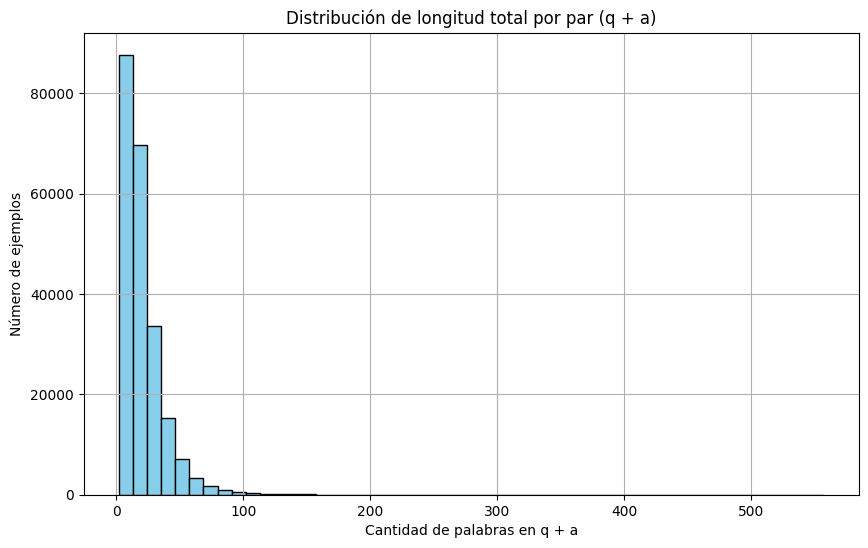

In [5]:
# Cantidad de palbras oraciones
dimensionDatos = [len(q.split() + a.split()) for q, a in pairs]

# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(dimensionDatos, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de longitud total por par (q + a)")
plt.xlabel("Cantidad de palabras en q + a")
plt.ylabel("Número de ejemplos")
plt.grid(True)
plt.show()

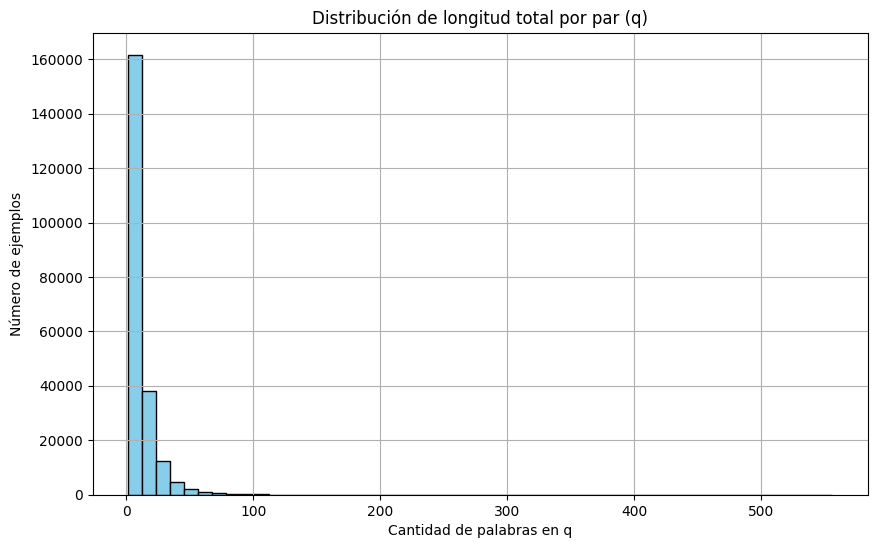

In [6]:
# Cantidad de palabras por preguntas
dimensionpreguntas = [len(q.split()) for q, a in pairs]

# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(dimensionpreguntas, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de longitud total por par (q)")
plt.xlabel("Cantidad de palabras en q")
plt.ylabel("Número de ejemplos")
plt.grid(True)
plt.show()

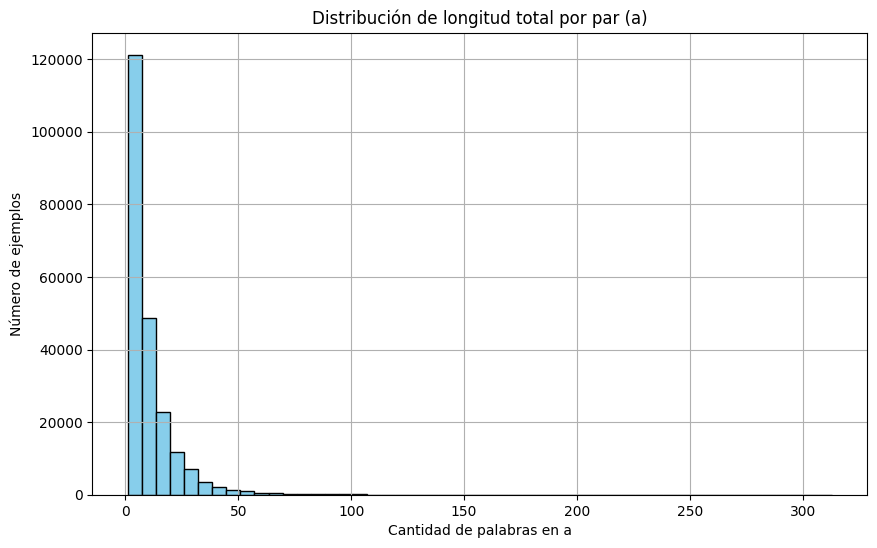

In [7]:
# Cantidad de palabras por respuestas
dimensionrespuestas = [len(a.split()) for q, a in pairs]

# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(dimensionrespuestas, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de longitud total por par (a)")
plt.xlabel("Cantidad de palabras en a")
plt.ylabel("Número de ejemplos")
plt.grid(True)
plt.show()

## Preparación de los datos para poder utilizarlos como entrada en modelos de deep learning. 

In [8]:
# filtrar la data a usar
pairs = pairs[:1000]

In [9]:
# limpiar las oraciones y separar preguntas y respuestas
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9?]+", " ", text)
    return text.strip()

#
preguntas = [clean_text(q) for q, a in pairs]
respuestas = ["<start> " + clean_text(a) + " <end>" for q, a in pairs]

In [ ]:
# Mostrar preguntas limpias
display(preguntas[:5])

# Mostrar respuestas limpias con etiquetas start y end
display(respuestas[:5])

['they do not',
 'i hope so',
 'let s go',
 'okay you re gonna need to learn how to lie',
 'no']

['<start> they do to <end>',
 '<start> she okay? <end>',
 '<start> wow <end>',
 '<start> no <end>',
 '<start> i m kidding you know how sometimes you just become this persona ? and you don t know how to quit? <end>']

In [ ]:
# Crear diccionario separado por espacios
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(preguntas + respuestas)

# Tokenizar los set de preguntas y respuestas
preguntas_seq = tokenizer.texts_to_sequences(preguntas)
respuestas_seq = tokenizer.texts_to_sequences(respuestas)

In [ ]:
# Definir variables
vocab_size = len(tokenizer.word_index) + 1
max_input_len = max(len(seq) for seq in preguntas_seq)
max_target_len = max(len(seq) for seq in respuestas_seq)

# standariza las sequencias tokenizadas para que compartan las mismas dimensiones
preguntas_pad = pad_sequences(preguntas_seq, maxlen=max_input_len, padding='post')
respuestas_pad = pad_sequences(respuestas_seq, maxlen=max_target_len, padding='post')

## Análisis sobre la selección del modelo de deep learning apropiado y la estrategia de estimación y calibración. 

## Desarrollo y calibración de modelos. 

In [22]:
# Definir
embedding_dim=100
latent_dim=256

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_len,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 131)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 108)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 131, 100)  │    247,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 108, 100)  │    247,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 256),     │    365,568 │ embedding_8[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 108,      │    365,568 │ embedding_9[0][0… │
│                     │ 256), (None,      │            │ lstm_8[0][1],     │
│                     │ 256), (None,      │            │ lstm_8[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 108, 2470) │    634,790 │ lstm_9[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,859,926 (7.10 MB)

 Trainable params: 1,859,926 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#
decoder_target_data = np.expand_dims(respuestas_pad, -1)

#
history = model.fit([preguntas_pad, respuestas_pad], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 0.5373 - val_loss: 0.6317
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.5474 - val_loss: 0.6297
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.5233 - val_loss: 0.6273
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.5204 - val_loss: 0.6250
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.5423 - val_loss: 0.6199
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.4978 - val_loss: 0.6180
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.5202 - val_loss: 0.6135
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.4964 - val_loss: 0.6096
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - loss: 0.5138 - val_loss: 0.6074
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.4965 - val_loss: 0.6067
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.5159 - val_loss: 0.6038
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step

In [25]:
encoder_model = Model(encoder_inputs, encoder_states)

In [26]:
# Entradas del decoder durante la predicción
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Embedding + LSTM + Dense
dec_emb2 = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs2] + decoder_states2)


## Visualización de resultados. 

In [37]:
def decode_sequence(input_seq):
    # 1. Codificar la entrada
    states_value = encoder_model.predict(input_seq)

    # 2. Empezar con el token '<start>'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['start']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Elegir la palabra con mayor probabilidad
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == 'end' or len(decoded_sentence.split()) > 10:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Actualizar la secuencia objetivo (con la palabra recién generada)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar los estados
        states_value = [h, c]

    return decoded_sentence.strip()


In [38]:
test_input = "hello"
seq = tokenizer.texts_to_sequences([test_input])
padded = pad_sequences(seq, maxlen=max_input_len, padding='post')
print(decode_sequence(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
<start> what do me me me me and and and and


## Implementación y demostración de la utilidad de los resultados. 